In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
def create_folder(folder_path):
    """
    Check whether the specified path exists or not
    Create a new directory if it does not exist 
    """
    isExist = os.path.exists(folder_path)
    if not isExist:
        os.makedirs(folder_path)
        
path = "./results/0_data_cleaning/"
create_folder(path)
file_name = "./Accident_Information.csv"
df = pd.read_csv(file_name, sep=',')
df =  df.rename(columns=str.lower)

In [34]:
with open(path + 'df_info.txt', 'w') as f:
    df.info(buf=f)

# Handling missing values

### Visulizing missing values NaN

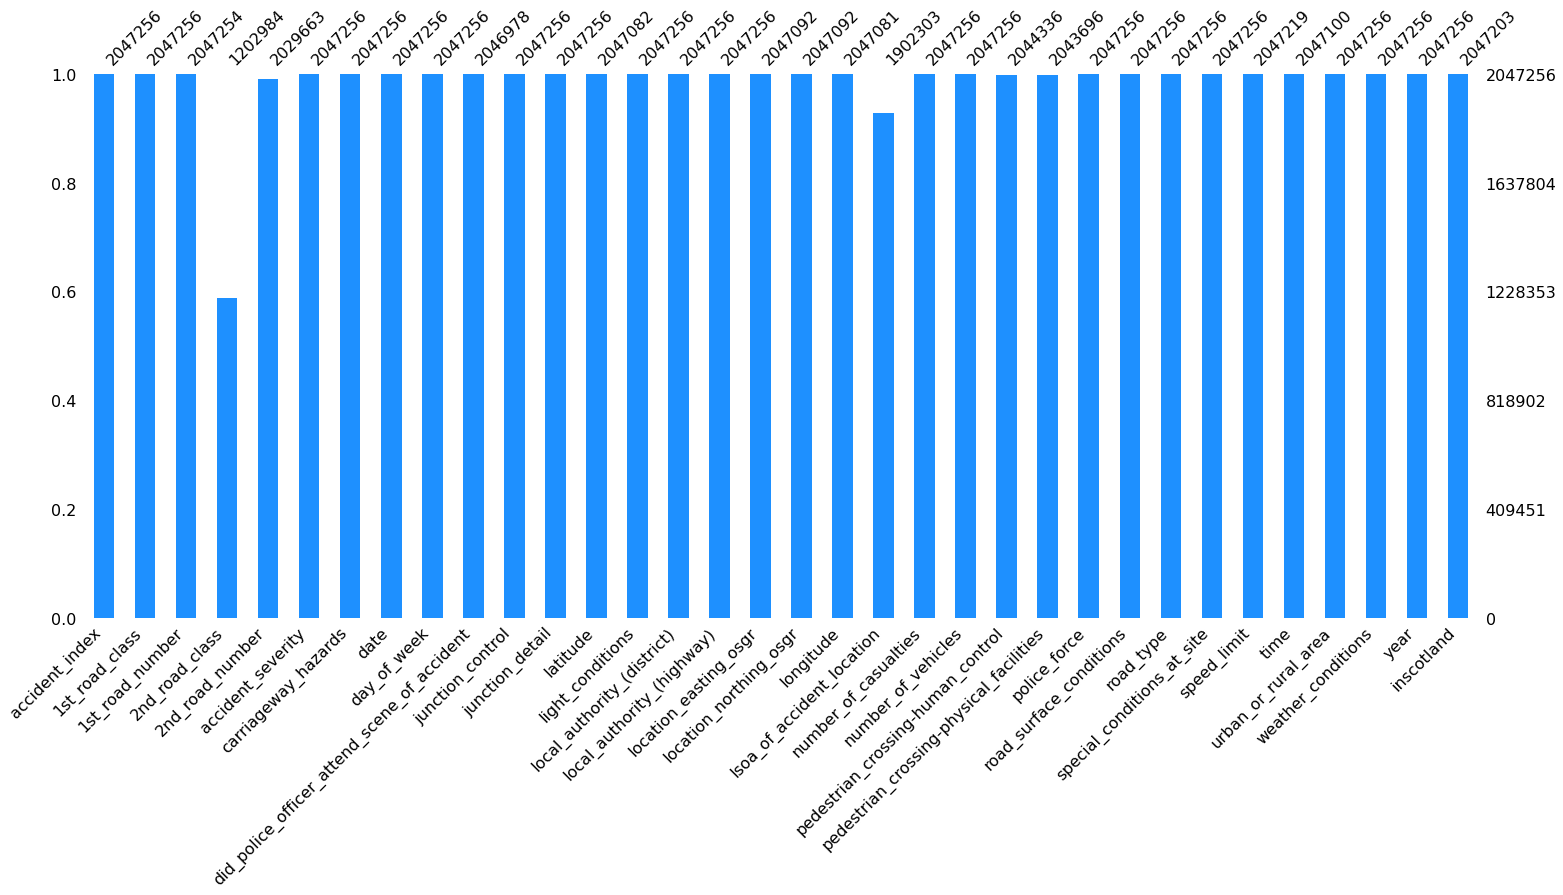

In [35]:
from plot_missing_values import missing_values_bars
nan_bar = missing_values_bars(df,color="dodgerblue")
fig_copy = nan_bar.get_figure()
fig_copy.savefig(path + 'nan_msno_bar.png', bbox_inches = 'tight')

### Calculate the mean of NaN missing values per column

In [36]:
df_missing_values = pd.DataFrame({
    "Missing values": df.isin([np.nan]).sum(),
    "Missing values (%)": (df.isin([np.nan]).mean() * 100).round(3)
})
df_missing_values = df_missing_values[ df_missing_values["Missing values"] != 0]
df_missing_values.to_csv(path + "df_missing_values.csv")
df_missing_values

,Missing values,Missing values (%)
1st_road_number,2,0.000
2nd_road_class,844272,41.239
2nd_road_number,17593,0.859
did_police_officer_attend_scene_of_accident,278,0.014
latitude,174,0.008
location_easting_osgr,164,0.008
location_northing_osgr,164,0.008
longitude,175,0.009
lsoa_of_accident_location,144953,7.080
pedestrian_crossing-human_control,2920,0.143


In [37]:
def drop_missing_values(df, min_percentage=15):
    n_rows = df.shape[0]
    serie = df.isin([np.nan, "-1", -1]).sum(axis=0) # Count number of NaN values
    serie_percentage = serie[serie.ne(0)].divide(n_rows/100).sort_values(ascending=False) #Percentage of missing values (%)
    to_drop = serie_percentage[serie_percentage.ge(min_percentage)].index.tolist()
    print("Features being dropped: {}".format(to_drop))
    df = df.drop(columns=to_drop, errors="ignore")
    df = df.dropna()
    for col in df.columns:
        df = df[ df[col]  != "-1"]
    return df

df = drop_missing_values(df)
df.shape

Features being dropped: ['2nd_road_class']


(1882016, 33)

In [38]:

month_lookup = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

columns = {
    "year": df["date"].apply(lambda x: x[0:4]), # Extract (year, month, day) from value for example (01/11/2016)
    "month": df["date"].apply(lambda x: month_lookup[int(x[5:7])] ),
    "day": df["day_of_week"],
    "hour": df["time"].apply(lambda x: str(x)[0:2]).astype(int)
}
df = df.assign(**columns)


In [39]:
to_drop = ['1st_road_number', '2nd_road_class',
       '2nd_road_number', 'date',
       'day_of_week', 'did_police_officer_attend_scene_of_accident',
       'local_authority_(district)', 'local_authority_(highway)',
       'location_easting_osgr', 'location_northing_osgr', 
       'lsoa_of_accident_location', 
       'police_force',
       'inscotland']
df = df.drop(columns=to_drop, errors="ignore")

In [40]:
df.columns

Index(['accident_index', '1st_road_class', 'accident_severity',
       'carriageway_hazards', 'junction_control', 'junction_detail',
       'latitude', 'light_conditions', 'longitude', 'number_of_casualties',
       'number_of_vehicles', 'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'road_surface_conditions',
       'road_type', 'special_conditions_at_site', 'speed_limit', 'time',
       'urban_or_rural_area', 'weather_conditions', 'year', 'month', 'day',
       'hour'],
      dtype='object')

In [41]:
df['speed_limit'].fillna((df['speed_limit'].mean()), inplace=True)
df['time'].fillna(0, inplace=True)
df['junction_control'] = df['junction_control'].replace(['Data missing or out of range'], 'Give way or uncontrolled')
def period(row):
    rdf = []
    if(type(row) == float):
        row = str(row)
        rdf = row.split(".")
    else:
        rdf = str(row).split(":"); # day -- 8am-8pm
        
    hr = rdf[0]
    if int(hr) > 8 and int(hr) < 20:
        return 1;
    else:
        return 2;
df['time'] = df['time'].apply(period) 

In [42]:
df.shape

(1882016, 24)

In [46]:
features = [
    "accident_severity",
    
    "latitude",
    "longitude",
    
    "year",
    "month",
    "hour",
    
    "urban_or_rural_area",
    "weather_conditions",

    "day",
    "junction_detail",
    "light_conditions",
    "road_surface_conditions",
    "road_type",
    "special_conditions_at_site",
    "speed_limit",
    "time",

    "1st_road_class",
    "carriageway_hazards",
    "junction_control",
    
    "number_of_casualties",
    "number_of_vehicles",
    "pedestrian_crossing-human_control",
    "pedestrian_crossing-physical_facilities",
]

df = df.dropna(subset=['speed_limit'])
df['speed_limit'] = df['speed_limit'].apply(lambda x: int(x) * 1.0 if x!= 'Data missing or out of range' else 0 ) # Converting str speeds to floats
df["accident_severity"] = df["accident_severity"].replace(to_replace= {'Fatal': 'Serious'})

df = df[features]

df = df.reset_index().rename(columns={"index": "id"})

In [47]:
df.head().T

,0,1,2,3,4
id,0,1,2,3,4
accident_severity,Serious,Slight,Slight,Slight,Slight
latitude,51.489096,51.520075,51.525301,51.482442,51.495752
longitude,-0.19117,-0.211708,-0.206458,-0.173862,-0.156618
year,2005,2005,2005,2005,2005
month,Jan,Jan,Jan,Jan,Jan
hour,17,17,0,10,21
urban_or_rural_area,Urban,Urban,Urban,Urban,Urban
weather_conditions,Raining no high winds,Fine no high winds,Fine no high winds,Fine no high winds,Fine no high winds
day,Tuesday,Wednesday,Thursday,Friday,Monday


In [30]:
df.to_csv( path + "dataset.csv", index=False)

### Preprocessing for ML

In [31]:
file_name = "./Accident_Information.csv"
df = pd.read_csv(file_name, sep=',')
df =  df.rename(columns=str.lower)

C:\Users\arfin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [32]:
df['junction_control'] = df['junction_control'].replace(['Data missing or out of range'], 'Give way or uncontrolled')
columns = {"day": df["day_of_week"]}
df = df.assign(**columns)


to_encode = {'light_conditions': {'Daylight': 0,
  'Darkness - lights lit': 1,
  'Darkness - no lighting': 1,
  'Darkness - lighting unknown': 1,
  'Darkness - lights unlit': 1,
  'Data missing or out of range': 0},
 'day': {'Saturday': 1,
  'Sunday': 1,
  'Monday': 0,
  'Tuesday': 0,
  'Wednesday': 0,
  'Thursday': 0,
  'Friday': 0},
 'special_conditions_at_site': {'None': 0,
  'Roadworks': 1,
  'Oil or diesel': 1,
  'Mud': 1,
  'Road surface defective': 1,
  'Auto traffic signal - out': 1,
  'Road sign or marking defective or obscured': 1,
  'Auto signal part defective': 1,
  'Data missing or out of range': 0},
 '1st_road_class': {'A': 1,
  'A(M)': 1,
  'B': 2,
  'C': 3,
  'Motorway': 4,
  'Unclassified': 1},
 'junction_control': {'Give way or uncontrolled': 1,
  'Auto traffic signal': 2,
  'Not at junction or within 20 metres': 3,
  'Stop sign': 4,
  'Authorised person': 5},
 'junction_detail': {'Not at junction or within 20 metres': 1,
  'T or staggered junction': 2,
  'Crossroads': 3,
  'Roundabout': 4,
  'Private drive or entrance': 5,
  'Other junction': 6,
  'Slip road': 7,
  'More than 4 arms (not roundabout)': 8,
  'Mini-roundabout': 9,
  'Data missing or out of range': 1},
 'road_surface_conditions': {'Dry': 1,
  'Wet or damp': 2,
  'Frost or ice': 3,
  'Snow': 4,
  'Flood over 3cm. deep': 5,
  'Data missing or out of range': 1},
 'road_type': {'Single carriageway': 1,
  'Dual carriageway': 2,
  'Roundabout': 3,
  'One way street': 4,
  'Slip road': 5,
  'Unknown': 0,
  'Data missing or out of range': 1},
 'urban_or_rural_area': {'Urban': 1, 'Rural': 2, 'Unallocated': 1},
 'weather_conditions': {"Fine no high winds": 1,
                             "Raining no high winds": 2,
                             "Raining + high winds": 3,
                             "Fine + high winds": 4,
                             "Snowing no high winds": 5,
                             "Fog or mist": 6,
                             "Snowing + high winds": 7,
                             "Unknown": 1,
                             "Other": 1,
                             "Data missing or out of range": 1 },
 'carriageway_hazards': {'None': 0,
  'Other object on road': 1,
  'Any animal in carriageway (except ridden horse)': 1,
  'Pedestrian in carriageway - not injured': 1,
  'Previous accident': 1,
  'Vehicle load on road': 1,
  'Data missing or out of range': 0}}

def modify_values(df, obj:dict):
    features = obj.keys()
    for feature, values in obj.items():
        df[feature] = df[feature].replace(to_replace= values)
    return df

df = modify_values(df, to_encode)



df['speed_limit'].fillna((df['speed_limit'].mean()), inplace=True)
df['time'].fillna(0, inplace=True)
def period(row):
    rdf = []
    if(type(row) == float):
        row = str(row)
        rdf = row.split(".")
    else:
        rdf = str(row).split(":"); # day -- 8am-8pm
        
    hr = rdf[0]
    if int(hr) > 8 and int(hr) < 20:
        return 1;
    else:
        return 2;
df['time'] = df['time'].apply(period) 

In [15]:
features = [
    "1st_road_class",
    "latitude",
    "longitude",
    "carriageway_hazards",
    "junction_control",
    "day",
    "speed_limit",
    "time",
    "urban_or_rural_area",
    "weather_conditions",
    "accident_severity",
    "road_surface_conditions",
    "road_type",
    "special_conditions_at_site",
    "junction_detail",
    "light_conditions"
]
new_df = df[features]

In [16]:
new_df

,1st_road_class,latitude,longitude,carriageway_hazards,junction_control,day,speed_limit,time,urban_or_rural_area,weather_conditions,accident_severity,road_surface_conditions,road_type,special_conditions_at_site,junction_detail,light_conditions
0,1,51.489096,-0.191170,0,1,0,30.0,1,1,2,Serious,2,1,0,1,0
1,2,51.520075,-0.211708,0,2,0,30.0,1,1,1,Slight,1,2,0,3,1
2,3,51.525301,-0.206458,0,1,0,30.0,2,1,1,Slight,1,1,0,1,1
3,1,51.482442,-0.173862,0,1,0,30.0,1,1,1,Slight,1,1,0,1,0
4,1,51.495752,-0.156618,0,1,0,30.0,2,1,1,Slight,2,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047251,1,55.311793,-3.450645,0,1,1,70.0,1,2,1,Slight,3,2,0,1,0
2047252,3,54.994285,-3.067116,1,1,0,20.0,1,1,1,Slight,1,1,0,1,0
2047253,1,55.053767,-3.225506,0,1,0,70.0,1,2,1,Slight,2,2,0,7,0
2047254,1,55.326392,-3.412672,0,1,0,60.0,1,2,1,Slight,1,1,0,1,0


In [17]:
new_df.to_csv("./results/3_machine_learning/train_dataset.csv")